# Assessing the Economic Impact of Wildfire focus on Building Losses in Texas
I-GUIDE Summer School 2024 Team 5 (Part2)

**Authors**: 
- Zhenlei Song songzl@tamu.edu
- Yoonjung Ahn yjahn@ku.edu
- Yan Xie yanxieyx@umich.edu
- Xiaoyu Xu xiaoyu.xu@siu.edu
- Jinyi Cai jinycai@uiowa.edu
- Sobia Shah sobiashah.libra15@gmail.com
- Harman Singh hxs5376@psu.edu

<br>**Created**: 8-8-24

This notebook introduced an example of assessing the economic impacts of wildfire on building losses in Texas, using multiple machine learning models. The results showed that the gradient boost performs the best with a MSE of 0.185; R2 score of 0.847.

***Please run this notebook using the I-GUIDE JupyterHub `geoai` kernal.***

<a id='top'></a>
## Contents
(Hyperlinks work only within the Jupuyter environment)
***Note:*** `Preprocessing` section takes hours. This notebook starts from `Methodology` -> `Data Analysis`.
- Introduction
- Research Question
- Data Sources
- Methodology
    - Preprocessing
    - [Data Analysis](#da)
    - [Preparation](#preparation)
    - [Machine Learning Models](#models)
        - [Linear Regression](#LR)
        - [Random Forest](#RF)
        - [Gradient Boosting](#GB)
- [Results](#results)
- [GeoEthics](#ethics)

<a id='da'></a>
### Data Analysis

#### Imports & Configs

In [1]:
!pip install geopandas
import geopandas as gpd
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeable


In [2]:
BASE_DIR = os.getcwd()
print(f"BASE_DIR is: {BASE_DIR}")
# DATASET_DIR = f"/share/Summer-School-2024/Team5/datasets"
DATASET_DIR = f"{BASE_DIR}/datasets"
print(f"DATASET_DIR is: {DATASET_DIR}")
OUTPUT_PATH = f"{BASE_DIR}/outputs"
print(f"DATASET_DIR is: {OUTPUT_PATH}")

BASE_DIR is: /home/jovyan/iguide-szl
DATASET_DIR is: /home/jovyan/iguide-szl/datasets
DATASET_DIR is: /home/jovyan/iguide-szl/outputs


#### Feature Column Distribution

In [3]:
merged_df = pd.read_csv(f"{DATASET_DIR}/results.csv")
merged_gdf = gpd.read_file(f"{DATASET_DIR}/results.geojson")

In [4]:
print(merged_gdf.shape)
print(merged_gdf.columns)
merged_gdf.head()

(6883, 38)
Index(['GeoId', 'Exposure-type', 'Burn-Probability',
       'Risk-2-Potential-Structures', 'Flame-Length-Over-8-Feet',
       'Flame-Length-Over-4-Feet', 'Conditional-Risk-2-Potential-Structures',
       'Conditional-Flame-Length', 'Population-Density',
       'Housing-Unit-Exposure', 'Housing-Unit-Density', 'Housing-Unit-Count',
       'Building-Density', 'Building-Cover', 'Building-Count',
       'Potential-Evapotranspiration', 'Mean-Temperature', 'Min-Temperature',
       'Max-Temperature', 'Precipitation', 'POPULATION', 'BUILDVALUE',
       'AGRIVALUE', 'WFIR_AFREQ', 'WFIR_EXPB', 'WFIR_EXPP', 'WFIR_EXPPE',
       'WFIR_EXPA', 'WFIR_EXPT', 'WFIR_HLRP', 'WFIR_HLRA', 'WFIR_EALB',
       'yb_min', 'yb_max', 'yb_mean', 'hc_mean', 'hc_sum', 'geometry'],
      dtype='object')


,GeoId,Exposure-type,Burn-Probability,Risk-2-Potential-Structures,Flame-Length-Over-8-Feet,Flame-Length-Over-4-Feet,Conditional-Risk-2-Potential-Structures,Conditional-Flame-Length,Population-Density,Housing-Unit-Exposure,...,WFIR_EXPT,WFIR_HLRP,WFIR_HLRA,WFIR_EALB,yb_min,yb_max,yb_mean,hc_mean,hc_sum,geometry
0,48157674100,0.143601,0.000013,0.000291,0.000000,0.011014,3.202309,0.377557,1851.207022,0.013412,...,1.141551e+09,0.000604,0.030198,96.079121,1977.0,1994.0,1981.400000,44.980769,2339.0,"POLYGON ((-95.61467 29.57828, -95.61339 29.578..."
1,48157674200,0.257008,0.000046,0.000875,0.000000,0.001689,12.820576,0.401274,1018.315399,0.071250,...,3.213280e+09,0.000604,0.030198,379.243129,1980.0,2010.0,1990.149254,22.246377,1535.0,"POLYGON ((-95.63989 29.58625, -95.63974 29.586..."
2,48441013501,0.870203,0.003103,0.123327,0.024073,0.350420,37.394016,4.288160,2.941036,2.751695,...,1.326225e+10,0.000066,0.010259,742196.438481,1897.0,2020.0,1972.590541,0.207799,2350.0,"POLYGON ((-100.15192 32.08412, -100.15188 32.0..."
3,48441013602,0.707624,0.002678,0.113393,0.031639,0.318994,36.829444,3.789351,3.861041,2.271997,...,1.024458e+10,0.000066,0.010259,404450.153379,1903.0,2020.0,1974.191092,0.262067,2264.0,"POLYGON ((-100.14955 32.2816, -100.1495 32.286..."
4,48441013601,0.391720,0.000694,0.027320,0.013679,0.191096,19.618786,2.097555,82.285826,0.473118,...,3.431890e+09,0.000066,0.010259,15632.203216,1900.0,2018.0,1958.250000,3.974843,1896.0,"POLYGON ((-100.03974 32.48854, -100.03064 32.4..."


In [5]:
print(merged_df.shape)
print(merged_df.columns)
merged_df.head()

(6883, 36)
Index(['Exposure-type', 'Burn-Probability', 'Risk-2-Potential-Structures',
       'Flame-Length-Over-8-Feet', 'Flame-Length-Over-4-Feet',
       'Conditional-Risk-2-Potential-Structures', 'Conditional-Flame-Length',
       'Population-Density', 'Housing-Unit-Exposure', 'Housing-Unit-Density',
       'Housing-Unit-Count', 'Building-Density', 'Building-Cover',
       'Building-Count', 'Potential-Evapotranspiration', 'Mean-Temperature',
       'Min-Temperature', 'Max-Temperature', 'Precipitation', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'WFIR_AFREQ', 'WFIR_EXPB', 'WFIR_EXPP',
       'WFIR_EXPPE', 'WFIR_EXPA', 'WFIR_EXPT', 'WFIR_HLRP', 'WFIR_HLRA',
       'WFIR_EALB', 'yb_min', 'yb_max', 'yb_mean', 'hc_mean', 'hc_sum'],
      dtype='object')


,Exposure-type,Burn-Probability,Risk-2-Potential-Structures,Flame-Length-Over-8-Feet,Flame-Length-Over-4-Feet,Conditional-Risk-2-Potential-Structures,Conditional-Flame-Length,Population-Density,Housing-Unit-Exposure,Housing-Unit-Density,...,WFIR_EXPA,WFIR_EXPT,WFIR_HLRP,WFIR_HLRA,WFIR_EALB,yb_min,yb_max,yb_mean,hc_mean,hc_sum
0,0.143601,0.000013,0.000291,0.000000,0.011014,3.202309,0.377557,1851.207022,0.013412,617.593884,...,0.000000e+00,1.141551e+09,0.000604,0.030198,96.079121,1977.0,1994.0,1981.400000,44.980769,2339.0
1,0.257008,0.000046,0.000875,0.000000,0.001689,12.820576,0.401274,1018.315399,0.071250,315.679710,...,0.000000e+00,3.213280e+09,0.000604,0.030198,379.243129,1980.0,2010.0,1990.149254,22.246377,1535.0
2,0.870203,0.003103,0.123327,0.024073,0.350420,37.394016,4.288160,2.941036,2.751695,1.374774,...,1.838134e+06,1.326225e+10,0.000066,0.010259,742196.438481,1897.0,2020.0,1972.590541,0.207799,2350.0
3,0.707624,0.002678,0.113393,0.031639,0.318994,36.829444,3.789351,3.861041,2.271997,1.811199,...,1.423031e+06,1.024458e+10,0.000066,0.010259,404450.153379,1903.0,2020.0,1974.191092,0.262067,2264.0
4,0.391720,0.000694,0.027320,0.013679,0.191096,19.618786,2.097555,82.285826,0.473118,38.094882,...,2.380856e+04,3.431890e+09,0.000066,0.010259,15632.203216,1900.0,2018.0,1958.250000,3.974843,1896.0


In [6]:
merged_df.describe()

,Exposure-type,Burn-Probability,Risk-2-Potential-Structures,Flame-Length-Over-8-Feet,Flame-Length-Over-4-Feet,Conditional-Risk-2-Potential-Structures,Conditional-Flame-Length,Population-Density,Housing-Unit-Exposure,Housing-Unit-Density,...,WFIR_EXPA,WFIR_EXPT,WFIR_HLRP,WFIR_HLRA,WFIR_EALB,yb_min,yb_max,yb_mean,hc_mean,hc_sum
count,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,...,6.883000e+03,6.883000e+03,6883.000000,6883.000000,6.883000e+03,6872.000000,6872.000000,6872.000000,6882.000000,6882.000000
mean,0.382713,0.000681,0.023996,0.008080,0.081089,14.555427,1.282483,1469.773668,0.631729,558.648447,...,8.634936e+05,4.327548e+09,0.000301,0.012679,3.325921e+04,1925.689319,2003.076688,1971.599379,31.501294,1637.441151
std,0.322077,0.001728,0.069989,0.020215,0.111269,12.589043,1.359133,1611.055713,1.560266,715.244816,...,1.144108e+07,6.148436e+09,0.000361,0.012421,1.341023e+05,34.569599,21.280314,20.791735,30.776586,1042.844510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065265,0.000000,0.017397,...,0.000000e+00,0.000000e+00,0.000002,0.000002,0.000000e+00,1810.000000,1889.000000,1871.500000,0.000000,0.000000
25%,0.103791,0.000018,0.000439,0.000001,0.002709,2.827928,0.203511,238.211210,0.016470,82.719554,...,0.000000e+00,4.300134e+08,0.000033,0.000792,4.346028e+01,1900.000000,1996.000000,1959.700000,5.518000,879.000000
50%,0.283113,0.000117,0.003097,0.000978,0.031370,10.196662,0.750139,1163.430878,0.096498,409.303301,...,0.000000e+00,2.311612e+09,0.000103,0.011258,3.014847e+02,1925.000000,2013.000000,1975.929433,24.334492,1481.000000
75%,0.649003,0.000725,0.021628,0.006578,0.113797,26.758920,2.031834,2158.803341,0.591229,752.477680,...,4.058750e+04,5.617622e+09,0.000604,0.030198,1.165616e+04,1950.000000,2018.000000,1986.172716,48.068392,2220.000000
max,0.999519,0.038436,1.497387,0.418746,0.622913,51.757701,10.956526,22003.453202,33.646976,8902.635468,...,6.616625e+08,9.188689e+10,0.002898,0.068980,2.801460e+06,2018.000000,2022.000000,2018.000000,287.833333,8293.000000


In [7]:
columns = merged_df.columns
# Inputing null values with 0
imputer = SimpleImputer(strategy="constant", fill_value=0.0)
imputer.fit(merged_df)
arr = imputer.transform(merged_df)
df = pd.DataFrame(data=arr, columns=columns)

In [8]:
df.isnull().sum()

Exposure-type                              0
Burn-Probability                           0
Risk-2-Potential-Structures                0
Flame-Length-Over-8-Feet                   0
Flame-Length-Over-4-Feet                   0
Conditional-Risk-2-Potential-Structures    0
Conditional-Flame-Length                   0
Population-Density                         0
Housing-Unit-Exposure                      0
Housing-Unit-Density                       0
Housing-Unit-Count                         0
Building-Density                           0
Building-Cover                             0
Building-Count                             0
Potential-Evapotranspiration               0
Mean-Temperature                           0
Min-Temperature                            0
Max-Temperature                            0
Precipitation                              0
POPULATION                                 0
BUILDVALUE                                 0
AGRIVALUE                                  0
WFIR_AFREQ

#### Standard Scaling

In [26]:
# scaling
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

In [10]:
def plot_histograms(df, filename):
    num_cols = df.shape[1]
    num_rows = (num_cols + 5) // 6

    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows))

    for i, col in enumerate(df.columns):
        row, col_num = divmod(i, 6)
        sns.histplot(df[col], kde=True, ax=axes[row, col_num])
        axes[row, col_num].set_title(f'Histogram of {col}')
    
    for j in range(i + 1, num_rows * 6):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}/{filename}", dpi=300)
    plt.show()
    

In [ ]:
# This step may take minutes
plot_histograms(df, "distrib_org.png")

In [ ]:
# This step may take minutes
plot_histograms(scaled_df, "distrib_scaled.png")

#### Correlation Matrix

In [ ]:
correlation_matrix = scaled_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt='.2f', annot_kws={"size": 7}, square=True, linewidths=0.5, cbar_kws={"shrink": 0.75})

# Add title and adjust layout
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()  # Adjust the padding between and around subplots
plt.savefig(f"{OUTPUT_PATH}/corr.png", dpi=300)
plt.show()


<a id='preparation'></a>
### Preparation

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

#### PCA Dimension Reduction

In [28]:
from sklearn.decomposition import PCA

In [29]:
columns_need_reduction = [
    'Exposure-type', 
    'Burn-Probability', 
    'Risk-2-Potential-Structures',
    'Flame-Length-Over-8-Feet', 
    'Flame-Length-Over-4-Feet',
    'Conditional-Risk-2-Potential-Structures', 
    'Conditional-Flame-Length'
]
df_A = scaled_df[columns_need_reduction]
df_B = scaled_df.drop(columns=columns_need_reduction)

print(df_A.shape)
print(df_B.shape)

(6883, 7)
(6883, 29)


In [30]:
# PCA dimension reduction
pca = PCA(n_components=2)
pca.fit(df_A)
df_A_reshaped = pca.transform(df_A)

In [31]:
print(type(df_A_reshaped))
df_A_reshaped.shape
# rename new columns
df_A_reshaped = pd.DataFrame(
    df_A_reshaped,
    columns=['pca_1','pca_2']
)

<class 'numpy.ndarray'>


In [32]:
scaled_df_new = pd.concat([df_A_reshaped, df_B], axis=1)
scaled_df_new.shape

(6883, 31)

In [33]:
target_var = 'WFIR_EALB'
def create_train_test_sets(scaled_df):

    # Split the data into training and testing sets
    label_column = target_var
    X = scaled_df.drop(columns=[label_column])
    y = scaled_df[label_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [34]:
# Train/Test split for model training
X_train, X_test, y_train, y_test = create_train_test_sets(scaled_df_new)
print(f"X_Train shape: {X_train.shape}")
print(f"X_Test shape: {X_test.shape}")
print(f"y_Train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_Train shape: (5506, 30)
X_Test shape: (1377, 30)
y_Train shape: (5506,)
y_test shape: (1377,)


<a id='models'></a>
### Machine Learning Models

In [35]:
performance_dict_list = []

<a id='LR'></a>
#### Linear Regression

In [36]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

y_pred_linear_regression = linear_regressor.predict(X_test)

# The coefficients
print("Coefficients: \n", linear_regressor.coef_)
# The mean squared error
mse = mean_squared_error(y_test, y_pred_linear_regression)
print("Mean squared error: %.2f" % mse)
r2 = r2_score(y_test, y_pred_linear_regression)
# The coefficient of determination: 1 is perfect prediction
print("r2 score: %.2f" % r2)

performance_dict_list.append({
    'model': "Linear Regression",
    'MSE': mse,
    'r2_score': r2
})

Coefficients: 
 [-7.96111272e-02  3.23359449e-02  2.19331868e-02  3.53949190e-01
 -2.05051639e-02 -3.05110663e-02  4.64507574e-03  7.39067909e-02
  1.29297666e-02  4.87314553e-02  5.59739517e+11 -2.28929888e+11
 -3.37666574e+11 -4.23255917e-02  2.19952635e-02 -1.64240101e-01
 -1.24031915e-02  4.12788058e-01  4.56423683e+08  1.18278344e+10
  5.85636955e+09  3.33956910e+07 -1.79468503e+10  3.24367816e-02
 -5.70813831e-02  1.30905033e-01  1.02867620e-01 -2.17835632e-01
  4.63176343e-03 -2.66459334e-02]
Mean squared error: 0.56
r2 score: 0.54


<a id='RF'></a>
#### Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Save the model
#joblib.dump(rf, 'random_forest_regressor_model.joblib')

# Predict on the test data
y_pred = rf.predict(X_test)

# Save the results to a CSV file
#results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#results.to_csv('random_forest_predictions.csv', index=False)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

performance_dict_list.append({
    'model': 'Random Forest',
    'MSE': mse,
    'r2_score': r2
})

Mean Squared Error: 0.29494663414030503
R^2 Score: 0.7571900475595393


<a id='GB'></a>
#### Gradient Boosting
Gradient boosting is a machine learning ensemble technique. It combines the predictions result of multiple weak learner model, specifically decision tree. By building a new model on the errors or residuals of previous model, gradient boosting optimizes the model performance sequentially. 

- How Gradient boosting works
    
    ![Untitled](https://prod-files-secure.s3.us-west-2.amazonaws.com/cb0dfb90-df60-4e9d-906b-98dc4a714221/c05ed080-a0a5-4dbb-9f6d-fb2bc4952f39/Untitled.png)
    
    The ensemble consists of M trees. Tree1 is trained using the feature matrix *X* and the labels *y*. The predictions labeled *y1(hat)* are used to determine the training set residual errors *r1*. Tree2 is then trained using the feature matrix *X* and the residual errors *r1* of Tree1 as labels. The predicted results *r1(hat)* are then used to determine the residual *r2*. The process is repeated until all the M trees forming the ensemble are trained. 
    

1. A loss function to be optimized
    1. The loss function used depends on the type of problem being solved. Regression task uses a squared error and classification task uses logarithmic loss.
2. A weak learner to make predictions
    1. Decision trees are used as the weak learner in gradient boosting. It is common to constrain the weak learners in some ways such as maximum number of layers, nodes, splits or leaf nodes. 
3. Additive model to add weak learner to minimize the loss function
    1. Gradient descent is used to minimize the loss

**Pros:**

1. **High Accuracy**: Gradient boosting can produce highly accurate predictive models by combining many weak learners (e.g., decision trees).
2. **Flexibility**: It can be applied to both regression and classification problems and is adaptable to different loss functions.
3. **Feature Importance**: The algorithm provides insights into feature importance, helping to understand which features contribute most to predictions.
4. **Handles Non-Linear Relationships**: Can capture complex non-linear patterns in the data due to its ensemble nature.

**Cons:**

1. **Training Time**: Gradient boosting can be slow to train, especially with large datasets, due to its sequential nature.
2. **Overfitting**: The algorithm can overfit if not properly regularized or if the trees are too deep.
3. **Parameter Tuning**: Requires careful tuning of multiple hyperparameters, such as learning rate, number of trees, and tree depth.
4. **Interpretability**: Models can be difficult to interpret, especially with many trees.

##### Native Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
gbr.fit(X_train, y_train)

# Save the model
#joblib.dump(gbr, 'gradient_boosting_regressor_model.joblib')

# Predict on the test data
y_pred_gb = gbr.predict(X_test)

# Save the results to a CSV file
#results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#results.to_csv('gradient_boosting_predictions.csv', index=False)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

performance_dict_list.append({
    'model': 'Gradient Boost',
    'MSE': mse,
    'r2_score': r2
})

Mean Squared Error: 0.1847466112898732
R^2 Score: 0.8479103990063116


##### XGBoost
**XGBoost (Extreme Gradient Boosting)** is an advanced implementation of gradient boosting that focuses on speed and performance. It was developed to address some limitations of the traditional gradient boosting algorithm. Here are some key improvements and features of XGBoost:

1. **Regularization**: XGBoost includes L1 (Lasso) and L2 (Ridge) regularization terms in its objective function, which helps prevent overfitting and improves model generalization.
2. **Parallelization**: The algorithm is designed to be parallelized, allowing it to take full advantage of multi-core processors and making it much faster than traditional gradient boosting implementations.
3. **Tree Pruning**: XGBoost uses a more effective tree pruning algorithm called "max depth" rather than the "depth-first" approach used in standard gradient boosting. This leads to more efficient and compact trees.
4. **Scalability**: XGBoost is highly scalable and can handle large datasets with millions of examples and features.

**Pros:**

1. **Speed and Performance**: XGBoost is optimized for speed and performance through parallel and distributed computing, making it significantly faster than traditional gradient boosting.
2. **Regularization**: Incorporates L1 (Lasso) and L2 (Ridge) regularization, which helps prevent overfitting and improves model generalization.
3. **Handling Missing Values**: Can automatically handle missing data, making preprocessing easier.
4. **Built-in Cross-Validation**: Supports built-in cross-validation, allowing for better model evaluation and hyperparameter tuning.
5. **Scalability**: Highly scalable and can efficiently handle large datasets.
6. **Tree Pruning**: Uses a more effective tree pruning algorithm that improves model efficiency and reduces overfitting.

**Cons:**

1. **Complexity**: The algorithm is more complex, with additional parameters to tune, which can make it challenging to configure optimally.
2. **Resource Intensive**: Despite optimizations, XGBoost can still be resource-intensive, requiring significant memory and computation power, especially with very large datasets.
3. **Sensitivity to Hyperparameters**: Like gradient boosting, XGBoost's performance is highly dependent on proper hyperparameter tuning, which can be time-consuming.
4. **Interpretability**: While feature importance is provided, the model itself can be difficult to interpret due to its ensemble nature.

In [41]:
!pip install xgboost
import xgboost as xgb

Defaulting to user installation because normal site-packages is not writeable


In [42]:
learning_rate = 0.2
max_depth = 4
reg_lambda = 1
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=3000, learning_rate=learning_rate,
                                 max_depth = max_depth, early_stopping_rounds=10, eval_metric="rmse", reg_lambda=reg_lambda)
eval_set = [(X_train, y_train), (X_test, y_test)]
print(f'\n Test with learning rate {learning_rate}, max_depth {max_depth} and reg_lambda {reg_lambda}: ')
# train the XGBoost model and do not record the loss
xgboost_model.fit(X_train, y_train, eval_set=eval_set, verbose=0)
# XGBoost prediction
y_pred_xgb_test = xgboost_model.predict(X_test)
# y_pred_xgb_train = xgboost_model.predict(X_train)
loss = xgboost_model.evals_result()

'''
# for training data
mse_xgb_train = mean_squared_error(y_train, y_pred_xgb_train)
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)
loss_rmse_train = loss['validation_0']['rmse'][-1]
'''
# for testing data
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb_test)
r2_xgb_test = r2_score(y_test, y_pred_xgb_test)
loss_rmse_test = loss['validation_1']['rmse'][-1]

print(f'Test MSE: {mse_xgb_test:.4f}')
print(f'Test R-squared: {r2_xgb_test:.4f}')
print(f'Test loss (RMSE): {loss_rmse_test:.4f}') 

performance_dict_list.append({
    'model': 'XGBoost',
    'MSE': mse_xgb_test,
    'r2_score': r2_xgb_test
})


 Test with learning rate 0.2, max_depth 4 and reg_lambda 1: 
Test MSE: 0.2564
Test R-squared: 0.7889
Test loss (RMSE): 0.5081


##### CatBoost

In [43]:
!pip install catboost
from catboost import CatBoostRegressor

Defaulting to user installation because normal site-packages is not writeable


In [44]:
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, loss_function='RMSE', verbose=100, l2_leaf_reg=1)
# early stopping setup
early_stopping_rounds = 10
# train the CatBoost model and record the loss every 5 epochs
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=early_stopping_rounds, verbose=5)
# CatBoost prediction
y_pred_cat = catboost_model.predict(X_test)
# calculate CatBoost mean squared error
mse_cat = mean_squared_error(y_test, y_pred_cat)
print(f'CatBoost Test MSE: {mse_cat:.4f}')
r2_cat = r2_score(y_test, y_pred_cat)
print(f"R^2 Score: {r2_cat}")

performance_dict_list.append({
    'model': 'CatBoost',
    'MSE': mse_cat,
    'r2_score': r2_cat
})

0:	learn: 0.9384313	test: 1.0767498	best: 1.0767498 (0)	total: 84.5ms	remaining: 1m 24s
5:	learn: 0.7773458	test: 0.9787390	best: 0.9787390 (5)	total: 237ms	remaining: 39.2s
10:	learn: 0.6547474	test: 0.9105491	best: 0.9105491 (10)	total: 382ms	remaining: 34.3s
15:	learn: 0.5559040	test: 0.8600644	best: 0.8600644 (15)	total: 527ms	remaining: 32.4s
20:	learn: 0.4785299	test: 0.8191277	best: 0.8191277 (20)	total: 671ms	remaining: 31.3s
25:	learn: 0.4115928	test: 0.7931703	best: 0.7931703 (25)	total: 813ms	remaining: 30.5s
30:	learn: 0.3551220	test: 0.7726832	best: 0.7726832 (30)	total: 989ms	remaining: 30.9s
35:	learn: 0.3078706	test: 0.7581116	best: 0.7581116 (35)	total: 1.16s	remaining: 31s
40:	learn: 0.2682733	test: 0.7464690	best: 0.7464690 (40)	total: 1.31s	remaining: 30.7s
45:	learn: 0.2350260	test: 0.7358779	best: 0.7358779 (45)	total: 1.46s	remaining: 30.4s
50:	learn: 0.2066629	test: 0.7255700	best: 0.7255700 (50)	total: 1.63s	remaining: 30.3s
55:	learn: 0.1842917	test: 0.7205581

<a id='results'></a>
## Results

/tmp/ipykernel_1262/540761234.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='MSE', data=performance_df, palette='Blues_d')
/tmp/ipykernel_1262/540761234.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='r2_score', data=performance_df, palette='Greens_d')


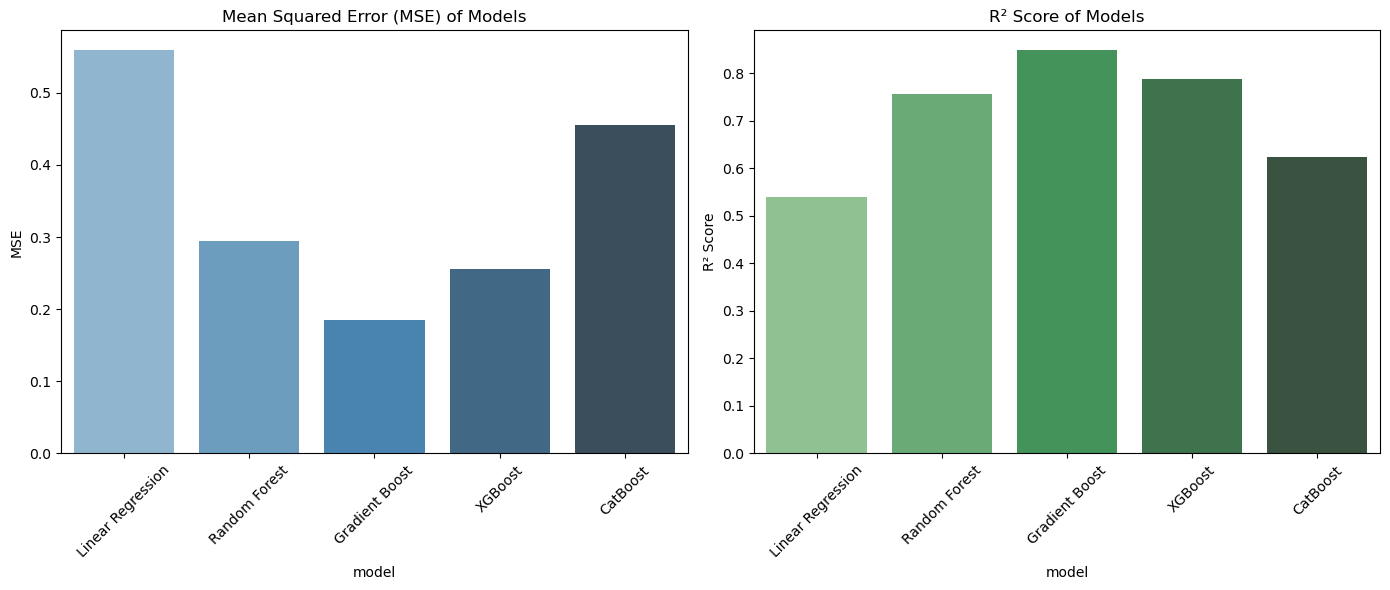

In [45]:
performance_df = pd.DataFrame(performance_dict_list)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='model', y='MSE', data=performance_df, palette='Blues_d')
plt.title('Mean Squared Error (MSE) of Models')
plt.xticks(rotation=45)
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
sns.barplot(x='model', y='r2_score', data=performance_df, palette='Greens_d')
plt.title('R² Score of Models')
plt.xticks(rotation=45)
plt.ylabel('R² Score')

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/performances.png", dpi=300)
plt.show()

In [48]:
# best performed model is native gradient boosting
y_pred_full_gb = gbr.predict(scaled_df_new.drop(columns='WFIR_EALB'))

In [49]:
gdf_map = gpd.GeoDataFrame(
    geometry=merged_gdf['geometry'],
    data={
        'EALB_True':scaled_df_new['WFIR_EALB'],
        'EALB_Pred':y_pred_full_gb,
        'GeoId': merged_gdf['GeoId']
    }
)

In [50]:
gdf_map.head()

,EALB_True,EALB_Pred,GeoId,geometry
0,-0.247315,-0.248250,48157674100,"POLYGON ((-95.61467 29.57828, -95.61339 29.578..."
1,-0.245204,-0.238829,48157674200,"POLYGON ((-95.63989 29.58625, -95.63974 29.586..."
2,5.286925,3.729020,48441013501,"POLYGON ((-100.15192 32.08412, -100.15188 32.0..."
3,2.768170,2.261093,48441013602,"POLYGON ((-100.14955 32.2816, -100.1495 32.286..."
4,-0.131454,-0.116274,48441013601,"POLYGON ((-100.03974 32.48854, -100.03064 32.4..."


/tmp/ipykernel_1262/602003022.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.93])


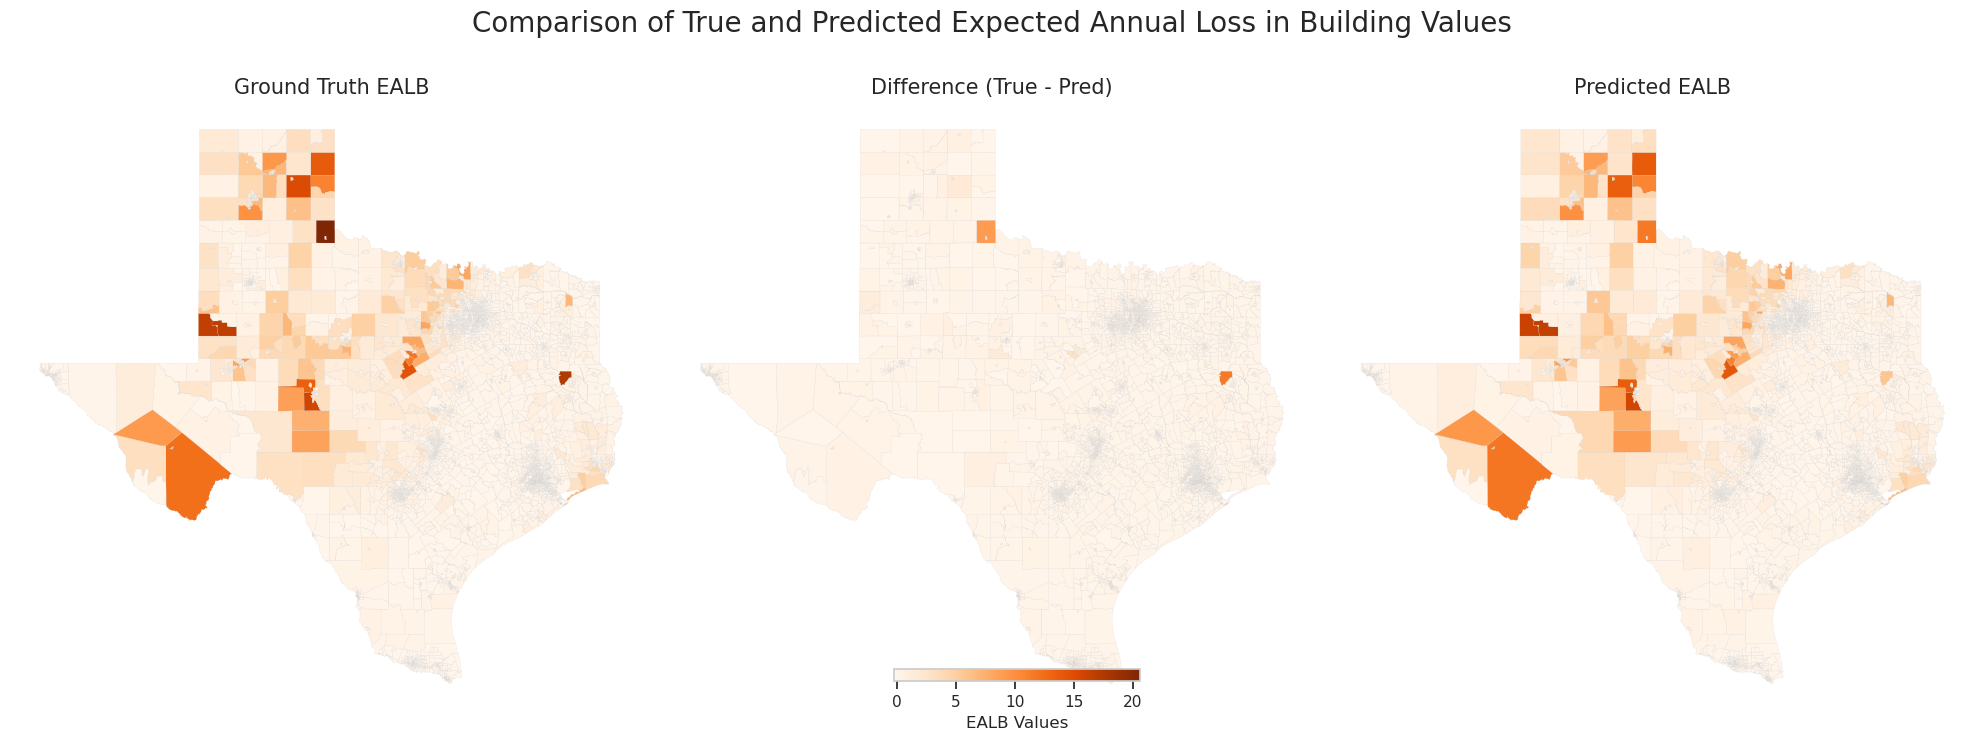

In [51]:
sns.set(style="whitegrid")

cmap = 'Oranges'
vmin = min(gdf_map['EALB_True'].min(), gdf_map['EALB_Pred'].min())
vmax = max(gdf_map['EALB_True'].max(), gdf_map['EALB_Pred'].max())

fig, axes = plt.subplots(1, 3, figsize=(20, 8)) 

gdf_map.plot(column='EALB_True', cmap=cmap, linewidth=0.1, ax=axes[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
axes[0].set_title('Ground Truth EALB', fontsize=15)
axes[0].axis('off') 

gdf_map.plot(column=gdf_map['EALB_True']-gdf_map['EALB_Pred'], cmap=cmap, linewidth=0.1, ax=axes[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
axes[1].set_title('Difference (True - Pred)', fontsize=15)
axes[1].axis('off')

gdf_map.plot(column='EALB_Pred', cmap=cmap, linewidth=0.1, ax=axes[2], edgecolor='0.8', vmin=vmin, vmax=vmax)
axes[2].set_title('Predicted EALB', fontsize=15)
axes[2].axis('off')

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
                    ax=axes, orientation='horizontal', fraction=0.02, pad=0.2) 
cbar.set_label('EALB Values', fontsize=12) 

plt.suptitle('Comparison of True and Predicted Expected Annual Loss in Building Values', fontsize=20, y=0.95)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])

plt.savefig(f"{DATASET_DIR}/Comparison_map.png", dpi=300)

plt.show()

<a id='ethics'></a>
# Data Science Ethics Checklist

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

## A. Data Collection
 - [x] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?
 * No, our research does not include any data involving human subjects.

 - [x] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?
 * When working with raster and vector data, an issue may arise when calculating values in raster data using vector boundaries. Specifically, there are cells that lie on the boundary line (Figure 1). To address this, we utilized the Shapely package in Python, which allows us to classify cells based on their overlap with the boundary. Cells that have 50% or more of their area inside the boundary are considered inside, while those with less than 50% are considered outside. Consequently, we excluded the values of cells classified as outside from our dataset. for further analysis we could consider incorporating Dasymetric method.
 

![Figure 1. raster and vector data](https://jo-wilkin.github.io/GEOG0030/coursebook/images/w9/rtovector.png)

 - [x] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?
 * The data utilized in our study were already deidentified or aggregated at a higher level to ensure privacy and confidentiality.

 - [x] **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?
 *  While our collected data doesn't include gender or race information directly, we plan looking at whether the modelshowed consistency across geographic regions (census tracts in this case). The fairness of the model across these regions can be assessed by calculating the true positive rate across census tracts to see if significant differences exist.

## B. Data Storage
 - [x] **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?
 * We plan to upload data in a priviately shared repository among the investigator

 - [x] **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?
 * This may not be applied to our research since did not have data that has individual data

 - [x] **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?
 * No, because the input and output of our project is aiming on annual average values, these informatin will be useful as historical records when new datasets come up. 

## C. Analysis
 - [x] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?
 * We thoroughly reviewed the metadata of each dataset to ensure a clear understanding of the data creation process and the meaning of each individual variable.

 - [x] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?
 * Missing data: At first, we didn't take building specific information (building year for example) into account. This could import biases. Then we added building specific datasets in census tract level.
 * Correlation: For the first version of processed datasets, there are 7 features, where there is a comparatively high correlation among them. Then we applied PCA dimension reduction on these features to keep core information and reduce correlation at the same time.

 - [x] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?
 * Yes

 - [x] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?
 * Yes

 - [x] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?
 * Yes

## D. Modeling
 - [x] **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?
 * Yes
 - [x] **D.2 Fairness across groups**: Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?
 * We have a plan to import features including race and gender distribution in census tract level to implement a Geographic Disparity Analysis on the correlation between model outputs and the race and gender distribution.
 - [x] **D.3 Metric selection**: Have we considered the effects of optimizing for our defined metrics and considered additional metrics?
 * Yes. We use 2 metrics, mean squared error (MSE) as loss, R square (R2) as accuracy to evaluate the performances of models. Plus, the geographic similarity of ground truth and predicted results is algo presented.
 - [x] **D.4 Explainability**: Can we explain in understandable terms a decision the model made in cases where a justification is needed?
 * Yes. The outputs of the prediction models represent the predicted census tract level annual averaged value of economic loss in buildings due to wildfire in Texas.
 - [x] **D.5 Communicate bias**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?
 * No

## E. Deployment
 - [x] **E.1 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?
 * Yes. We would determine at which step among data acquisition, data processing, model running, and model deployment the problem occurs, and then update it at the corresponding stage.
 - [x] **E.2 Roll back**: Is there a way to turn off or roll back the model in production if necessary?
 * Yes. We tracted model versions on Github. So we can roll back if necessary.
 - [x] **E.3 Concept drift**: Do we test and monitor for concept drift to ensure the model remains fair over time?
 * No.
 - [x] **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?
 * No.

*Data Science Ethics Checklist generated with [deon](http://deon.drivendata.org).*